In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Drive 마운트 
# 학습에 사용할 데이터를 본인의 Drive에 업로드하고 해당 위치를 적어주기 
!unzip -qq drive/MyDrive/ai/seq2seq_NMTdata.zip -d .
!rm -r __MACOSX

아래 코드는 pytorch seq2seq 공식 튜토리얼 문서를 참조했습니다. 

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [ ]:
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 데이터 불러오기

In [ ]:
SOS_token = 0 # Start of Sentence 
EOS_token = 1 # End of Sentence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS & EOS 카운트 

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, trim, unicode -> Ascii and 문자가 아닌 글자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일 읽고 줄 단위로 나누기 
    lines = open('seq2seq_NMTdata/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 각 줄을 pairs 단위로 나누고 normalize 함수 진행 
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Lang 객체 생성, 필요시 reverse 진행
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
# 1. 파일을 읽어서 줄로 나누고 pair로 나누기 
# 2. normalize 시키고 pair를 filter에 통과시키기(Max legnth와 prefixes에 맞는 애들로)
# 3. Pairs 안에 있는 문장으로 단어 리스트 생성 
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis heureuse de t avoir invite .', 'i m glad i invited you .']


# Encoder

입력으로 들어오는 언어의 내용을 잘 간추려 하나의 vector로 만듦

In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Decoder

Encoder에서 만들어 낸 vector를 이용해 출력 단어를 뱉어줌

In [ ]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.softmax(self.out(output[0]))
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 한 pair의 Train 과정

전체 학습 데이터가 아니라 language1과 language2 데이터 한 쌍의 학습 과정

lang1을 encoding 하고 lang2로 decoding해서 loss를 구하고 각각의 optimizer로 update

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, \
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], 
                                                               encoder_hidden,
                                                               encoder_cell)
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    loss = 0
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: 네트워크가 뱉어낸 출력물과는 상관없이 실제 정답을 decoder의 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, 
                                                                   decoder_hidden,
                                                                   decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: 네트워크가 뱉어낸 출력물 자체를 decoder의 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, 
                                                                   decoder_hidden,
                                                                   decoder_cell)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

# Helper 함수

진행도와 남은 학습 상황을 보여주는 도우미 함수

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# PLT show 함수

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()

    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# 전체 Train 과정

전체 학습 과정을 담당하는 코드 

다음의 과정이 담겨있다

1. 타이머 시작 세팅 
2. Encoder와 Decoder optimizer 선언 
3. Loss 선언 
4. 전체 데이터를 학습에 사용할 수 있는 형태로 불러오기 
5. 각 데이터 pair를 train 시키기 
6. 전체 loss update 
7. 시각화

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0   # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# 실제 학습 시작 지점

1m 24s (- 19m 39s) (5000 6%) 3.0378
2m 41s (- 17m 27s) (10000 13%) 2.5254
3m 59s (- 15m 59s) (15000 20%) 2.2390
5m 19s (- 14m 37s) (20000 26%) 2.0373
6m 37s (- 13m 15s) (25000 33%) 1.8327
7m 55s (- 11m 52s) (30000 40%) 1.6713
9m 12s (- 10m 31s) (35000 46%) 1.5063
10m 29s (- 9m 11s) (40000 53%) 1.4064
11m 46s (- 7m 51s) (45000 60%) 1.3045
13m 4s (- 6m 32s) (50000 66%) 1.1667
14m 21s (- 5m 13s) (55000 73%) 1.0724
15m 38s (- 3m 54s) (60000 80%) 0.9817
16m 55s (- 2m 36s) (65000 86%) 0.9096
18m 12s (- 1m 18s) (70000 93%) 0.8183
19m 30s (- 0m 0s) (75000 100%) 0.7531


<Figure size 432x288 with 0 Axes>

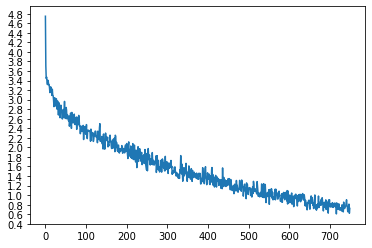

In [ ]:
hidden_size = 256
n_iter = 75000
print_every = 5000

encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words).to(device)

trainIters(encoder, decoder, n_iter, print_every=print_every)

# Evaluate

Decoding과정에서 만들어진 t 시점의 출력물이 t+1 시점의 입력으로 들어가도록 설계

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                                   encoder_hidden,
                                                                   encoder_cell)
        
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, 
                                                                   decoder_hidden,
                                                                   decoder_cell)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder, decoder)

> vous etes trop maigrichonnes .
= you re too skinny .
< you re too too . <EOS>

> les etudes sociales m interessent beaucoup .
= i m very interested in social studies .
< i m very much to lot . <EOS>

> nous sommes tres heureux .
= we re very happy .
< we re very happy . <EOS>

> elles sont furieuses apres toi .
= they re mad at you .
< they re mad at you . <EOS>

> je ne suis pas sourde .
= i m not deaf .
< i m not asleep . <EOS>

> il est habitue a voyager .
= he s accustomed to traveling .
< he is used to traveling . <EOS>

> ce ne sont pas mes regles .
= they re not my rules .
< they re not my words . <EOS>

> je ne suis pas d humeur .
= i m not in the mood .
< i m not in the mood . <EOS>

> je vais etre mariee .
= i m going to get married .
< i m going to get married . <EOS>

> tu es acariatre .
= you re cantankerous .
< you re crafty . <EOS>



In [ ]:
sentence = 'il est sur le bureau .'
output_words = evaluate(encoder, decoder, sentence)
output_sentence = ' '.join(output_words)
print('>', sentence)
print('<', output_sentence)

> il est sur le bureau .
< he is on the office . <EOS>
